In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import torch
from torch import nn

In [2]:
import os

In [3]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans


In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ndcg_score

In [5]:
import torch

from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.interactions import Interactions
from spotlight.evaluation import rmse_score


In [6]:
import optuna 
from scipy.sparse import coo_matrix, csr_matrix, lil_matrix, vstack, hstack
from scipy import sparse


In [7]:
def get_train(data, train_ind):
    
    train_data = data.loc[train_ind][data.columns[:3]]
    train_data = train_data.rename(columns={train_data.columns[1]: "item"})
    train_user = train_data.user.value_counts().index.to_numpy()
    train_user = np.sort(train_user)
    
    return train_data, train_user

def get_test_val(data, test_ind):

    test_data = data.loc[test_ind][data.columns[:3]]
    test_data = test_data.rename(columns={test_data.columns[1]: "item"})
    test_user = test_data.user.value_counts().index.to_numpy()
    test_user = np.sort(test_user)

    #count interation in test set
    test_inter_count ={} 
    interaction = test_data.user.value_counts()

    for i, count in enumerate(interaction):
        if count >= 10:
            test_inter_count[interaction.index[i]] = 10
        else:
            test_inter_count[interaction.index[i]] = count
            
    return test_data, test_user, test_inter_count

### Reading Data

In [8]:
root = 'C:/Users/bbb50/Desktop/Python/hw3/Yelp'

In [9]:
user_business = pd.read_feather(os.path.join(root, 'user_business_fea.ftr'), use_threads=True)
user_business = user_business[user_business.columns[1:4]]
user_list = user_business.user.value_counts().index.to_numpy()
user_list = np.sort(user_list)

business_list = user_business.business.value_counts().index.to_numpy()
business_list = np.sort(business_list).astype(str)

n_users = user_list.shape[0]
n_items = business_list.shape[0]

data = user_business

In [10]:
train_path = os.path.join(root, 'train')
val_path = os.path.join(root, 'val')
test_path = os.path.join(root, 'test')

In [11]:
def cf(name , user_based ):
    sim_options = {'name': name, 'user_based': user_based}
    model = KNNWithMeans(sim_options=sim_options)
    model.fit(train_)
    
    rate = []
    for ind in tqdm(range(test_data.shape[0])):

        uid = test_data.iloc[ind].user
        iid = test_data.iloc[ind]['item']
        est = model.predict(uid, iid, verbose=False).est
        rate.append(est)

    test_data['rate_pred'] = rate
    
    rmse = mean_squared_error(test_data.rate, test_data.rate_pred, squared=False)
    recall = []
    ndcg = []

    for tu in tqdm(test_user):

        top = test_data[test_data.user == tu].sort_values(by=['rate_pred'], ascending=False)[:test_inter_count[tu]]
        den = top[top.rate > 3.5].shape[0]
        num = top[(top.rate > 3.5) & (top.rate_pred > 3.5)].shape[0]

        if den == 0:
            recall.append(0)
        else:
            recall.append(num/den)

        if test_inter_count[tu] != 1:
            ndcg.append(ndcg_score(top.rate.values.reshape(1, -1), top.rate_pred.values.reshape(1, -1)))
        else:
            ndcg.append(ndcg_score(np.append(top.rate.values, 0).reshape(1, -1), np.append(top.rate_pred.values, 0).reshape(1, -1)))

    return rmse, np.array(recall).mean(), np.array(ndcg).mean()

In [12]:
u_b_c = []
u_b_p = []
i_b_c = []
i_b_p = []
for i in range(5):
    
    print('=================================================================')
    print('num:', i)
    train_ind = np.load(os.path.join(train_path, 'train_ind'+ str(i) +'.npy'))
    val_ind = np.load(os.path.join(val_path, 'val_ind'+ str(i) +'.npy'))
    test_ind = np.load(os.path.join(test_path, 'test_ind'+ str(i) +'.npy'))

    train_data, train_user = get_train(data, train_ind)    
    test_data, test_user, test_inter_count = get_test_val(data, test_ind)
    val_data, val_user, val_inter_count = get_test_val(data, val_ind)
    
    reader = Reader(rating_scale=(1, 5))
    train_ = Dataset.load_from_df(train_data[['user', 'item', 'rate']], reader) 
    train_ = train_.build_full_trainset()
    train_.n_users = n_users
    train_.n_items = n_items 

    rmse, recall, ndcg = cf(name = 'cosine', user_based = True)
    u_b_c.append([rmse, recall, ndcg])
    rmse, recall, ndcg = cf(name = 'pearson', user_based = True)
    u_b_p.append([rmse, recall, ndcg])
    rmse, recall, ndcg = cf(name = 'cosine', user_based = False)
    i_b_c.append([rmse, recall, ndcg])
    rmse, recall, ndcg = cf(name = 'pearson', user_based = False)
    i_b_p.append([rmse, recall, ndcg])

num: 0
Computing the cosine similarity matrix...


  1%|▍                                                                           | 236/37692 [00:00<00:15, 2359.62it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7857/7857 [00:15<00:00, 493.14it/s]


Computing the pearson similarity matrix...


  2%|█▊                                                                          | 927/37692 [00:00<00:07, 4677.15it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7857/7857 [00:15<00:00, 510.56it/s]


Computing the cosine similarity matrix...


  2%|█▊                                                                          | 904/37692 [00:00<00:08, 4364.14it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7857/7857 [00:14<00:00, 526.43it/s]


Computing the pearson similarity matrix...


  2%|█▊                                                                          | 896/37692 [00:00<00:08, 4506.98it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7857/7857 [00:16<00:00, 487.09it/s]


num: 1
Computing the cosine similarity matrix...


  0%|▎                                                                           | 184/37691 [00:00<00:20, 1830.41it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7900/7900 [00:14<00:00, 548.59it/s]


Computing the pearson similarity matrix...


  0%|                                                                                        | 0/37691 [00:00<?, ?it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7900/7900 [00:14<00:00, 530.49it/s]


Computing the cosine similarity matrix...


  0%|                                                                                        | 0/37691 [00:00<?, ?it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7900/7900 [00:17<00:00, 452.48it/s]


Computing the pearson similarity matrix...


  1%|▌                                                                           | 285/37691 [00:00<00:13, 2850.00it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7900/7900 [00:16<00:00, 479.18it/s]


num: 2
Computing the cosine similarity matrix...


  2%|█▎                                                                          | 620/37691 [00:00<00:11, 3201.10it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7920/7920 [00:13<00:00, 592.93it/s]


Computing the pearson similarity matrix...


  2%|█▌                                                                          | 766/37691 [00:00<00:10, 3671.89it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7920/7920 [00:14<00:00, 532.28it/s]


Computing the cosine similarity matrix...


  1%|▊                                                                           | 404/37691 [00:00<00:09, 4039.61it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7920/7920 [00:15<00:00, 497.89it/s]


Computing the pearson similarity matrix...


  2%|█▊                                                                          | 890/37691 [00:00<00:08, 4339.71it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7920/7920 [00:17<00:00, 457.45it/s]


num: 3
Computing the cosine similarity matrix...


  1%|█                                                                           | 547/37691 [00:00<00:12, 2860.70it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7884/7884 [00:14<00:00, 543.69it/s]


Computing the pearson similarity matrix...


  1%|▌                                                                           | 297/37691 [00:00<00:13, 2786.78it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7884/7884 [00:14<00:00, 557.19it/s]


Computing the cosine similarity matrix...


  1%|▉                                                                           | 465/37691 [00:00<00:08, 4626.50it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7884/7884 [00:12<00:00, 615.99it/s]


Computing the pearson similarity matrix...


  3%|██                                                                         | 1051/37691 [00:00<00:07, 5081.19it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7884/7884 [00:11<00:00, 691.77it/s]


num: 4
Computing the cosine similarity matrix...


  1%|▌                                                                           | 295/37691 [00:00<00:12, 2938.07it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7883/7883 [00:11<00:00, 687.87it/s]


Computing the pearson similarity matrix...


100%|█████████████████████████████████████████████████████████████████████████████| 7883/7883 [00:11<00:00, 673.34it/s]


Done computing similarity matrix.
Computing the cosine similarity matrix...


  0%|                                                                                        | 0/37691 [00:00<?, ?it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7883/7883 [00:12<00:00, 618.02it/s]


Computing the pearson similarity matrix...


  1%|▉                                                                           | 463/37691 [00:00<00:08, 4586.47it/s]

Done computing similarity matrix.


100%|█████████████████████████████████████████████████████████████████████████████| 7883/7883 [00:11<00:00, 665.31it/s]


In [13]:
print('u_b_c', np.array(u_b_c).mean(axis=0))
print('u_b_p', np.array(u_b_p).mean(axis=0))
print('i_b_c', np.array(i_b_c).mean(axis=0))
print('i_b_p', np.array(i_b_p).mean(axis=0))

u_b_c [1.13856805 0.67230058 0.9680588 ]
u_b_p [1.15045956 0.66736779 0.96410296]
i_b_c [1.18011582 0.68407809 0.96962677]
i_b_p [1.19119478 0.6926838  0.97001484]


### MF

In [12]:
torch.backends.cudnn.benchmark = True
def mf_explicit(epoch, embedding_dim, l2, lr):

    model = ExplicitFactorizationModel(loss='regression',
                                       embedding_dim = 32,  # latent dimensionality
                                       n_iter=epoch,  # number of epochs of training
                                       batch_size=1024,  # minibatch size
                                       l2 = l2,  # strength of L2 regularization
                                       learning_rate = lr,
                                       use_cuda=torch.cuda.is_available())
    model.fit(train_inter, verbose=False)
    
    rate = []
    for ind in tqdm(range(test_data.shape[0])):

        uid = test_data.iloc[ind].user
        iid = test_data.iloc[ind]['item']
        est = model.predict(user_ids=np.array([uid]))[iid]
        rate.append(est)

    test_data['rate_pred'] = rate
    
    rmse = mean_squared_error(test_data.rate, test_data.rate_pred, squared=False)
    recall = []
    ndcg = []

    for tu in tqdm(test_user):

        top = test_data[test_data.user == tu].sort_values(by=['rate_pred'], ascending=False)[:test_inter_count[tu]]
        den = top[top.rate > 3.5].shape[0]
        num = top[(top.rate > 3.5) & (top.rate_pred > 3.5)].shape[0]

        if den == 0:
            recall.append(0)
        else:
            recall.append(num/den)

        if test_inter_count[tu] != 1:
            ndcg.append(ndcg_score(top.rate.values.reshape(1, -1), top.rate_pred.values.reshape(1, -1)))
        else:
            ndcg.append(ndcg_score(np.append(top.rate.values, 0).reshape(1, -1), np.append(top.rate_pred.values, 0).reshape(1, -1)))

    return rmse, np.array(recall).mean(), np.array(ndcg).mean()

In [13]:
mf_exp = []

for i in range(5):
    
    print('=================================================================')
    print('num:', i)
    train_ind = np.load(os.path.join(train_path, 'train_ind'+ str(i) +'.npy'))
    val_ind = np.load(os.path.join(val_path, 'val_ind'+ str(i) +'.npy'))
    test_ind = np.load(os.path.join(test_path, 'test_ind'+ str(i) +'.npy'))

    train_data, train_user = get_train(data, train_ind)    
    test_data, test_user, test_inter_count = get_test_val(data, test_ind)
    val_data, val_user, val_inter_count = get_test_val(data, val_ind)
    
    train_inter = Interactions(user_ids = train_data[train_data.columns[0]].values,
                           item_ids=train_data[train_data.columns[1]].values,
                           ratings=train_data[train_data.columns[2]].values,
                              num_users=n_users,
                              num_items=n_items)
    
    rmse, recall, ndcg = mf_explicit(30, 32, 1e-09, 0.001)
    mf_exp.append([rmse, recall, ndcg])

num: 0


100%|█████████████████████████████████████████████████████████████████████████████| 7857/7857 [00:10<00:00, 727.14it/s]


num: 1


100%|█████████████████████████████████████████████████████████████████████████████| 7900/7900 [00:11<00:00, 717.05it/s]


num: 2


100%|█████████████████████████████████████████████████████████████████████████████| 7920/7920 [00:11<00:00, 676.55it/s]


num: 3


100%|█████████████████████████████████████████████████████████████████████████████| 7884/7884 [00:11<00:00, 687.90it/s]


num: 4


100%|█████████████████████████████████████████████████████████████████████████████| 7883/7883 [00:10<00:00, 758.25it/s]


In [14]:
print('mf_exp', np.array(mf_exp).mean(axis=0))

mf_exp [1.73105626 0.44018147 0.97067572]


In [29]:
print('mf_exp', np.array(mf_exp).mean(axis=0))

mf_exp [1.735958   0.43255789 0.97072467]


In [22]:
i = 1

train_ind = np.load(os.path.join(train_path, 'train_ind'+ str(i) +'.npy'))
val_ind = np.load(os.path.join(val_path, 'val_ind'+ str(i) +'.npy'))
test_ind = np.load(os.path.join(test_path, 'test_ind'+ str(i) +'.npy'))

train_data, train_user = get_train(data, train_ind)    
test_data, test_user, test_inter_count = get_test_val(data, test_ind)
val_data, val_user, val_inter_count = get_test_val(data, val_ind)


In [23]:
train_inter = Interactions(user_ids = train_data[train_data.columns[0]].values,
                       item_ids=train_data[train_data.columns[1]].values,
                       ratings=train_data[train_data.columns[2]].values,
                          num_users=n_users,
                          num_items=n_items)

val_inter = Interactions(user_ids = val_data[train_data.columns[0]].values,
                       item_ids=val_data[train_data.columns[1]].values,
                       ratings=val_data[train_data.columns[2]].values)

test_inter = Interactions(user_ids = test_data[train_data.columns[0]].values,
                       item_ids=test_data[train_data.columns[1]].values,
                       ratings=test_data[train_data.columns[2]].values)

In [24]:
from matplotlib import pyplot as plt

 90%|█████████████████████████████████████████████████████████████████████████▌        | 35/39 [04:31<00:56, 14.13s/it]

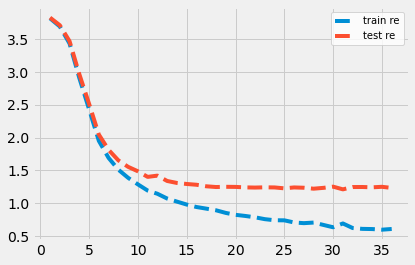

 92%|███████████████████████████████████████████████████████████████████████████▋      | 36/39 [04:46<00:43, 14.40s/it]

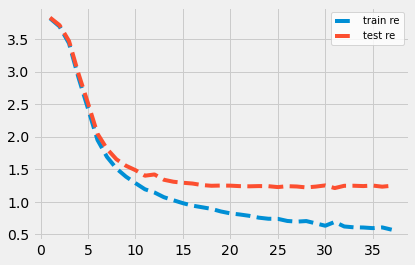

 95%|█████████████████████████████████████████████████████████████████████████████▊    | 37/39 [05:03<00:30, 15.01s/it]

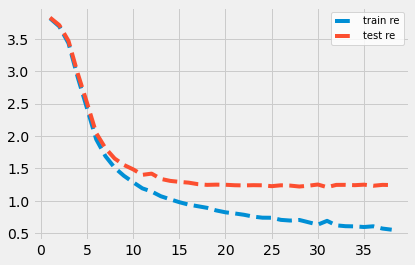

 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [05:19<00:15, 15.48s/it]

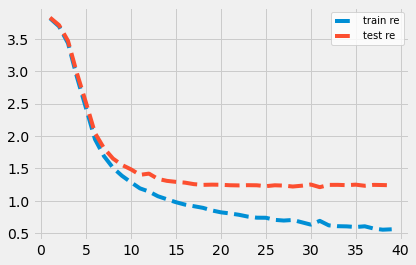

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [05:37<00:00,  8.64s/it]


In [16]:


rmse_test_re = []
rmse_train_re = []
for i in tqdm(range(1,40)):
    values = np.arange(1, i+1)
    model = ExplicitFactorizationModel(loss='regression',
                                       embedding_dim = 32,  # latent dimensionality
                                       n_iter=i,  # number of epochs of training
                                       batch_size=1024,  # minibatch size
                                       l2 = 1e-9,  # strength of L2 regularization
                                       learning_rate = 1e-3,
                                       use_cuda=torch.cuda.is_available())
    model.fit(train_inter, verbose=False)
    rmse_test_re.append(rmse_score(model, val_inter))
    rmse_train_re.append(rmse_score(model, train_inter))
    
    if i > 35:
        with plt.style.context('fivethirtyeight'):

            plt.plot(values, rmse_train_re, label='train re', linestyle='--')
            plt.plot(values, rmse_test_re, label='test re', ls='--')
        plt.legend()
        plt.show()
        fig = plt.gcf() 

        plt.close(fig) 

In [25]:
def objective(trial):

    param = {
            "embedding_dim" : trial.suggest_categorical("embedding_dim", [32, 16, 64]),
            "l2" : trial.suggest_categorical("l2", [1e-11, 1e-9, 1e-10]),            
            "learning_rate" : trial.suggest_categorical("learning_rate", [1e-3, 1e-4, 1e-2]),
        }
    
    model = ExplicitFactorizationModel(loss='regression',
                                       embedding_dim = param['embedding_dim'],  # latent dimensionality
                                       n_iter=30,  # number of epochs of training
                                       batch_size=1024,  # minibatch size
                                       l2 = param['l2'],  # strength of L2 regularization
                                       learning_rate = param['learning_rate'],
                                       use_cuda=torch.cuda.is_available())


    model.fit(train_inter, verbose=False)


    

    return rmse_score(model, val_inter)

In [ ]:
'embedding_dim': 32, 'l2': 1e-09, 'learning_rate': 0.001

In [26]:
# i =1
study = optuna.create_study(direction="minimize") # Create a new study.
study.optimize(objective, n_trials=30)

[I 2021-06-11 00:25:17,677] A new study created in memory with name: no-name-1b21e2aa-27c9-4770-a648-36da83138f17
[I 2021-06-11 00:25:43,361] Trial 0 finished with value: 1.4126244876889755 and parameters: {'embedding_dim': 32, 'l2': 1e-11, 'learning_rate': 0.01}. Best is trial 0 with value: 1.4126244876889755.
[I 2021-06-11 00:26:08,782] Trial 1 finished with value: 1.3927425675418237 and parameters: {'embedding_dim': 32, 'l2': 1e-10, 'learning_rate': 0.01}. Best is trial 1 with value: 1.3927425675418237.
[I 2021-06-11 00:26:33,980] Trial 2 finished with value: 1.5352900797406837 and parameters: {'embedding_dim': 16, 'l2': 1e-09, 'learning_rate': 0.01}. Best is trial 1 with value: 1.3927425675418237.
[I 2021-06-11 00:26:58,903] Trial 3 finished with value: 3.6037594963224304 and parameters: {'embedding_dim': 16, 'l2': 1e-10, 'learning_rate': 0.0001}. Best is trial 1 with value: 1.3927425675418237.
[I 2021-06-11 00:27:24,442] Trial 4 finished with value: 1.3994065409329302 and paramete

In [21]:
# i =0
study = optuna.create_study(direction="minimize") # Create a new study.
study.optimize(objective, n_trials=30)

[I 2021-06-11 00:11:24,847] A new study created in memory with name: no-name-ed056ce2-fd45-4675-8881-03c7fe5849bd
[I 2021-06-11 00:11:53,069] Trial 0 finished with value: 1.4007659853841412 and parameters: {'embedding_dim': 32, 'l2': 1e-11, 'learning_rate': 0.01}. Best is trial 0 with value: 1.4007659853841412.
[I 2021-06-11 00:12:20,151] Trial 1 finished with value: 1.264506722943555 and parameters: {'embedding_dim': 16, 'l2': 1e-11, 'learning_rate': 0.001}. Best is trial 1 with value: 1.264506722943555.
[I 2021-06-11 00:12:47,256] Trial 2 finished with value: 3.607061631809734 and parameters: {'embedding_dim': 16, 'l2': 1e-11, 'learning_rate': 0.0001}. Best is trial 1 with value: 1.264506722943555.
[I 2021-06-11 00:13:16,627] Trial 3 finished with value: 1.2403892419631584 and parameters: {'embedding_dim': 64, 'l2': 1e-10, 'learning_rate': 0.001}. Best is trial 3 with value: 1.2403892419631584.
[I 2021-06-11 00:13:42,457] Trial 4 finished with value: 1.2716453895607218 and parameters